<a href="https://colab.research.google.com/github/ego-alt/segmentation-from-scratch/blob/master/instance_seg/instance_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ego-alt/segmentation-from-scratch

In [3]:
%cd segmentation-from-scratch/instance_seg/

/content/segmentation-from-scratch/instance_seg


In [4]:
!unzip -o -j -q -d ./full_images /content/drive/MyDrive/MP6843_img_full.zip
!unzip -o -j -q -d ./labels /content/drive/MyDrive/MP6843_inst.zip

In [5]:
from train import Match, CellImages, InitModel, ImageTest
from torch.utils.data import DataLoader

In [6]:
lb_root, im_root = './labels', './full_images'
handler = Match(lb_root, im_root)

In [20]:
w1, labels3d = handler.main('alt', (256, 256))

In [21]:
train = CellImages(w1[0:70], labels3d[0:70])
train_loader = DataLoader(train, 
                          batch_size=5, shuffle=False, 
                          collate_fn=lambda x:list(zip(*x)))

test_loader = DataLoader(CellImages(w1[70:90], labels3d[70:90]), 
                          batch_size=5, shuffle=False,
                          collate_fn=lambda x:list(zip(*x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


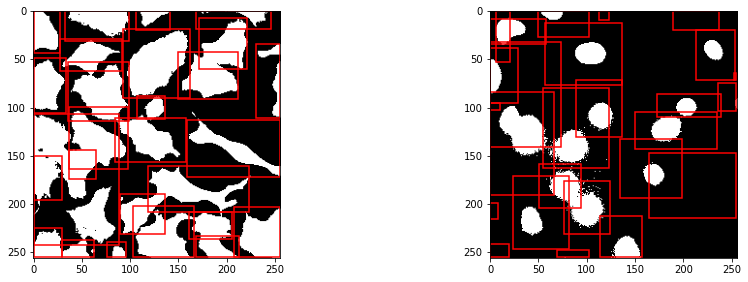

In [22]:
import torchvision
import matplotlib.pyplot as plt
from matplotlib import patches

images, labels = next(iter(train_loader))  # Batch of 5

def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15,10))
    images = list(images)
    labels = list(labels)
    for i in range(n):
        out = torchvision.utils.make_grid(images[i])  
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1,2,0)) * 255)
        l = labels[i]['boxes'].cpu().numpy()
        l[:,2] = l[:,2] - l[:,0]
        l[:,3] = l[:,3] - l[:,1]
        for j in range(len(l)):
            ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],
                                           linewidth=1.5,
                                           edgecolor='r',
                                           facecolor='none')) 

view(images=images, labels=labels, n=2, std=1, mean=0)

In [23]:
epochs = 50
run = InitModel()

In [24]:
run.main(train_loader, test_loader, epochs=epochs)

Epoch: [0]  [ 0/14]  eta: 0:00:21  lr: 0.000156  loss: 7.8231 (7.8231)  loss_classifier: 0.6222 (0.6222)  loss_box_reg: 0.8839 (0.8839)  loss_mask: 1.9833 (1.9833)  loss_objectness: 4.0647 (4.0647)  loss_rpn_box_reg: 0.2689 (0.2689)  time: 1.5300  data: 0.0498  max mem: 5462
Epoch: [0]  [10/14]  eta: 0:00:05  lr: 0.001693  loss: 2.7970 (4.5792)  loss_classifier: 0.5659 (0.5160)  loss_box_reg: 0.8612 (0.7252)  loss_mask: 0.8567 (1.1236)  loss_objectness: 0.7751 (1.9079)  loss_rpn_box_reg: 0.2617 (0.3065)  time: 1.4329  data: 0.0383  max mem: 5801
Epoch: [0]  [13/14]  eta: 0:00:01  lr: 0.002000  loss: 2.7237 (3.9317)  loss_classifier: 0.4769 (0.4668)  loss_box_reg: 0.6577 (0.6274)  loss_mask: 0.8091 (1.0363)  loss_objectness: 0.4393 (1.5416)  loss_rpn_box_reg: 0.2167 (0.2596)  time: 1.3879  data: 0.0336  max mem: 5801
Epoch: [0] Total time: 0:00:19 (1.3882 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:04  model_time: 0.8241 (0.8241)  evaluator_time: 0.2802 (0.2802)  ti

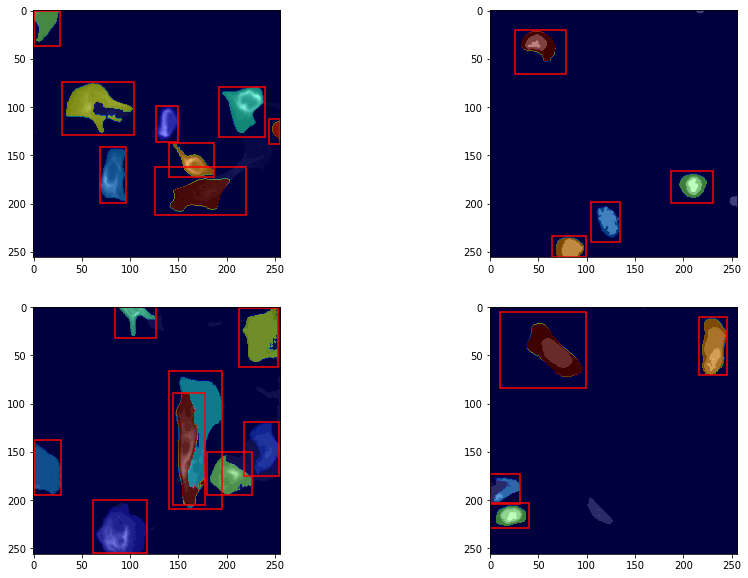

In [74]:
testone = ImageTest(w1[93:98])
testone.main(run.model, 0.90)

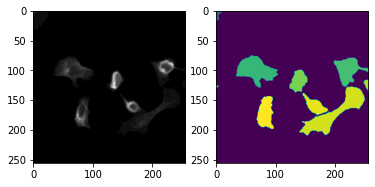

In [151]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(w1[93] * 15, cmap='gray', vmin = 0, vmax = 255)
axarr[1].imshow(labels3d[93].squeeze())